# Домашняя работа №2

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

In C:\Users\zelen\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zelen\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zelen\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\zelen\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zelen\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

## Environment

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

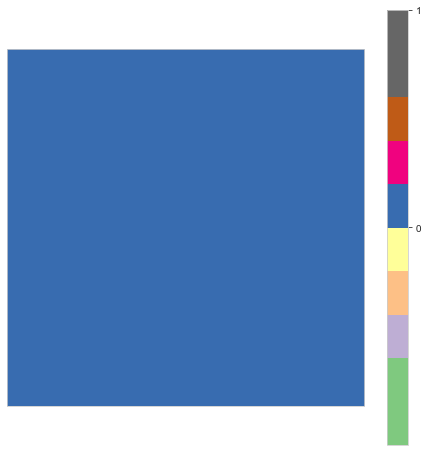

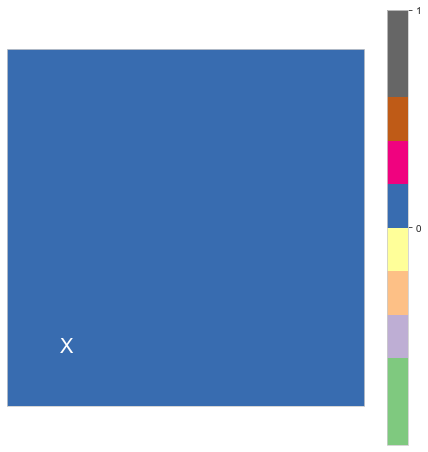

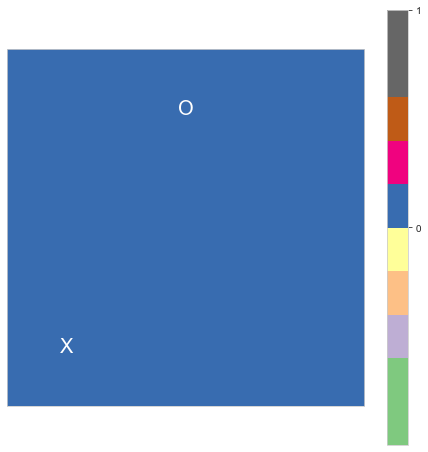

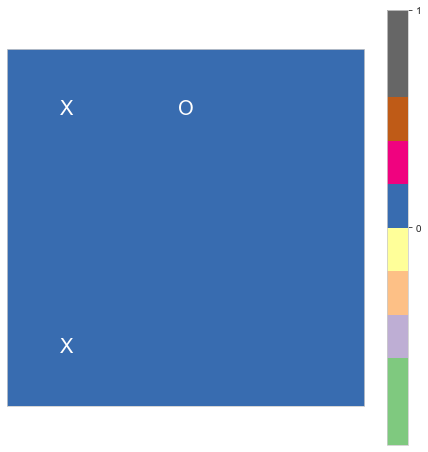

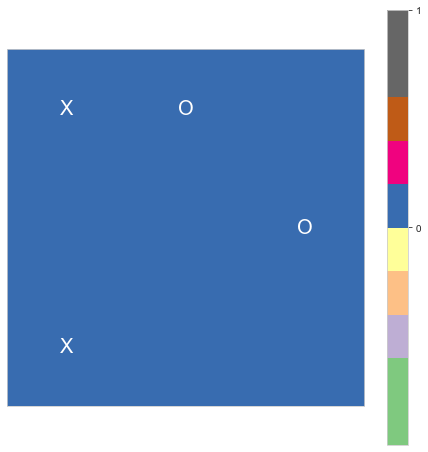

Крестики выиграли!


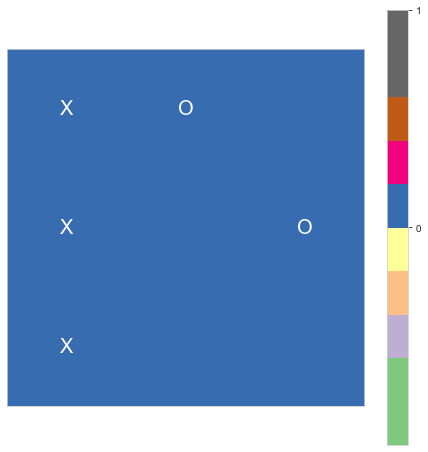

In [6]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

### Q-learning

#### Обучим агента который ходит первым (крестики)

In [7]:
eps = 0.1
alpha = 0.1
gamma = 0.1

In [8]:
n_cols = 3
n_rows = 3
n_wins = 3

In [9]:
def Q_znach(Q, state, actions, action):
    if state not in Q:
        Q[state] = np.ones(len(actions))
    i = actions.index(action)
    return Q[state][i]

In [10]:
def make_move(state, eps, n_rows, n_cols, Q):
    razm = n_rows * n_cols
    actions = [i for i in range(razm) if state[i] == '1']
    
    if random.random() < eps:
        move = random.choice(actions)
        return (int(move / n_cols), int(move % n_cols))
    Q_values = [Q_znach(Q, state, actions, a) for a in actions]
    max_Q_value = max(Q_values)
    
    if Q_values.count(max_Q_value) > 1:
        best_actions = [i for i in range(len(actions)) if Q_values[i] == max_Q_value]
        best_move = actions[random.choice(best_actions)]
        
    else:
        best_move = actions[Q_values.index(max_Q_value)]
    return (int(best_move / n_cols), int(best_move % n_cols))

In [11]:
def q_learning(steps, reward, n_cols, alpha, gamma, Q):
    max_Q_new = 0
    for state, action in steps[::-1]:
        action_int = action[0]*n_cols + action[1]
        razm = n_rows * n_cols
        actions = [i for i in range(razm) if state[i] == '1']
        prev_Q = Q_znach(Q, state,actions, action_int)
        Q[state][actions.index(action_int)] = prev_Q + alpha*(reward + gamma * max_Q_new - prev_Q)
        max_Q_new = np.max(Q[state])

In [12]:
def learning_episode(env, eps, n_rows, n_cols, Q):
    env.reset()
    state = env.getState()[0]
    done = False
    steps = []
    while not done:
        action = make_move(state, eps, n_rows, n_cols, Q)
        steps.append((state, action))
        next_state, reward, done, _ = env.step(action)
        if not done:
            next_next_state, reward_op, done, _ = env.step(random.choice(env.getEmptySpaces()))
            state = next_next_state[0]
            if done:
                reward = reward_op
    return steps, reward

In [13]:
env_3 = TicTacToe(n_cols=3, n_rows=3, n_win=3)

In [14]:
Q_X_3 = {}
rez_sum = 0
avg_rew = []
for i in range(100000):
    steps, reward = learning_episode(env_3, eps, n_rows, n_cols, Q_X_3)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_X_3)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

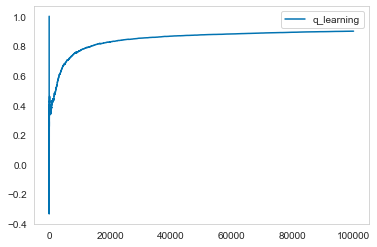

In [15]:
plt.plot(avg_rew, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

Обучим агента который ходит вторым 

In [16]:
def learning_episode_0(env, eps, n_rows, n_cols, Q):
    env.reset()
    next_next_state, reward_op, done, _ = env.step(random.choice(env.getEmptySpaces()))
    state = next_next_state[0]
    steps = []
    while not done:
        action = make_move(state, eps, n_rows, n_cols, Q)
        steps.append((state, action))
        next_state, reward, done, _ = env.step(action)
        if not done:
            next_next_state, reward_op, done, _ = env.step(random.choice(env.getEmptySpaces()))
            state = next_next_state[0]
            state_t = tuple(state)
            if done:
                reward = reward_op
    return steps, reward

In [17]:
env_3 = TicTacToe(n_cols=3, n_rows=3, n_win=3)

In [18]:
Q_0_3 = {}
rez_sum = 0
avg_rew = []
for i in range(100000):
    steps, reward = learning_episode_0(env_3, eps, n_rows, n_cols, Q_0_3)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_0_3)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

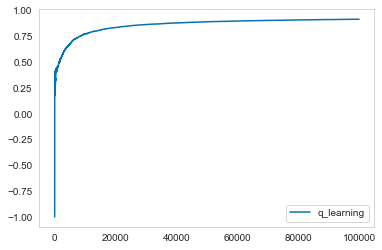

In [19]:
plt.plot(avg_rew, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

#### Проведем обучение для доски 4x4

In [50]:
n_cols = 4
n_rows = 4
n_wins = 3

In [51]:
env_4 = TicTacToe(n_cols=4, n_rows=4, n_win=3)

Обучим агента который ходит первым (крестики)

In [52]:
Q_X_4 = {}
rez_sum = 0
avg_rew = []
for i in range(1000000):
    steps, reward = learning_episode(env_4, eps, n_rows, n_cols, Q_X_4)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_X_4)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

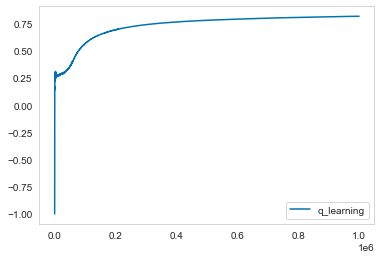

In [53]:
plt.plot(avg_rew, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

Обучим агента который ходит вторым

In [54]:
Q_0_4 = {}
rez_sum = 0
avg_rew = []
for i in range(1000000):
    steps, reward = learning_episode_0(env_4, eps, n_rows, n_cols, Q_0_4)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_0_4)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

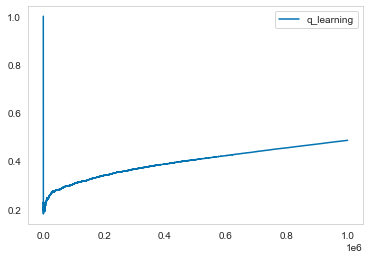

In [55]:
plt.plot(avg_rew, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

Проведем обучение для доски 5x5

In [20]:
n_cols = 5
n_rows = 5
n_wins = 3

In [21]:
env_5 = TicTacToe(n_cols=5, n_rows=5, n_win=3)

Обучим агента который ходит первым (крестики)

In [61]:
Q_X_5 = {}
rez_sum = 0
avg_rew = []
for i in range(1000000):
    steps, reward = learning_episode(env_5, eps, n_rows, n_cols, Q_X_5)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_X_5)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

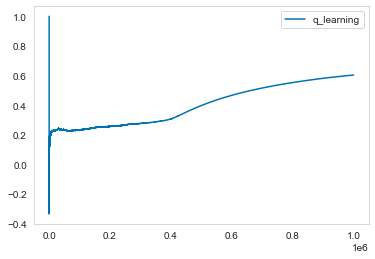

In [62]:
plt.plot(avg_rew, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

Обучим агента который ходит вторым

In [24]:
Q_0_5 = {}
rez_sum = 0
avg_rew = []
for i in range(5000000):
    steps, reward = learning_episode_0(env_5, eps, n_rows, n_cols, Q_0_5)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_0_5)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

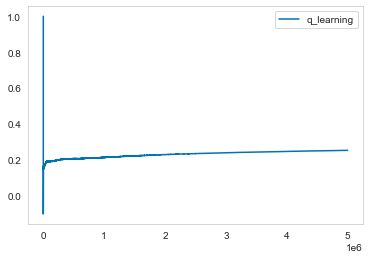

In [25]:
plt.plot(avg_rew, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

для игры 5х5 модель медленно обучается 

### DQN

In [18]:
def state_to_tensor(state, n_rows, n_cols):
    x = torch.zeros(1, 3, n_rows, n_cols)
    for i in range(len(state)):
        if state[i] == '1':
            k = 0
            j = i // n_cols
            l = i % n_cols
        elif state[i] == '0':
            k = 1
            j = i // n_cols
            l = i % n_cols
        else:
            k = 2
            j = i // n_cols
            l = i % n_cols
        x[0][k][j][l] = 1
    
    return x

In [19]:
s = '102010111'
state_to_tensor(s,3,3)

tensor([[[[1., 0., 0.],
          [0., 1., 0.],
          [1., 1., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 0., 0.]],

         [[0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.]]]])

In [20]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [21]:
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv_out_size = 5
        self.n_cols = 3
        self.n_rows = 3
        self.conv = nn.Conv2d(3, self.conv_out_size, kernel_size=3, stride=1,padding=1)
        self.l2 = nn.Linear(self.conv_out_size*self.n_cols*self.n_rows, self.n_cols*self.n_rows)


    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size*self.n_cols*self.n_rows)
        x = self.l2(x)
        return x

In [22]:
class DQNmodel():
    def __init__(self):
        self.env = TicTacToe(n_cols=3, n_rows=3, n_win=3)
        self.n_cols = 3
        self.n_rows = 3
        self.action_size = 9
        self.model = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.01)

        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state = state_to_tensor(self.env.getState()[0], self.n_rows, self.n_cols)
        x_plays = random.choice([-1, 1])
        if not x_plays:
            state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
            state = state_to_tensor(state[0], self.n_rows, self.n_cols)
        while True:
           
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state)
                else:
                    action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
            next_state = state_to_tensor(next_state[0], self.n_rows, self.n_cols)
            

            if not done:
                next_state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                next_state = state_to_tensor(next_state[0], self.n_rows, self.n_cols)
            if not x_plays:
                if reward in [-1, 1]:
                    reward = reward * -1
            
            transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            if done:
                break

            state = next_state
  
            
        
        
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        print(1)
        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        print(2)
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    def test_play(self, x_plays, n_episodes=1000):
        rewards = 0
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            state = state_to_tensor(state[0], self.n_rows, self.n_cols)
            done = False
            while not done:
                if cur_turn == x_plays:
                    idx = self.select_greedy_action(state)
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
                
                state = state_to_tensor(state, self.n_rows, self.n_cols)
            if reward != -10:
                rewards += reward * x_plays
            else:
                if cur_turn == x_plays:
                    rewards += reward
        return rewards / n_episodes

In [23]:
dqn = DQNmodel()

rewards_x = []
rewards_0 = []
for e in range(3001):
    dqn.run_episode(e)
    if e % 100 == 0:
        rewards_x.append(dqn.test_play(1))
        rewards_0.append(dqn.test_play(-1))

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


0.805


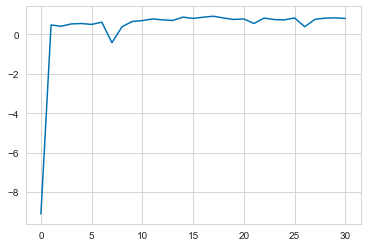

In [24]:
plt.plot(rewards_x)
print(rewards_x[-1])

-0.319


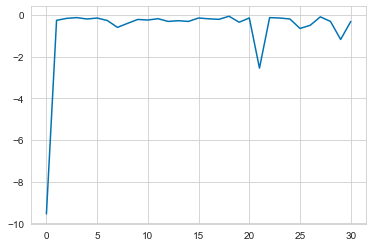

In [25]:
plt.plot(rewards_0)
print(rewards_0[-1])

### игра на поле 4x4

In [10]:
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv_out_size = 5
        self.n_cols = 4
        self.n_rows = 4
        self.conv = nn.Conv2d(3, self.conv_out_size, kernel_size=3, stride=1,padding=1)
        self.l2 = nn.Linear(self.conv_out_size*self.n_cols*self.n_rows, self.n_cols*self.n_rows)


    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size*self.n_cols*self.n_rows)
        x = self.l2(x)
        return x

In [13]:
class DQNmodel():
    def __init__(self):
        self.env = TicTacToe(n_cols=4, n_rows=4, n_win=3)
        self.n_cols = 4
        self.n_rows = 4
        self.action_size = 16
        self.model = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.01)

        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state = state_to_tensor(self.env.getState()[0], self.n_rows, self.n_cols)
        x_plays = random.choice([-1, 1])
        if not x_plays:
            state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
            state = state_to_tensor(state[0], self.n_rows, self.n_cols)
        while True:
           
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state)
                else:
                    action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
            next_state = state_to_tensor(next_state[0], self.n_rows, self.n_cols)
            

            if not done:
                next_state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                next_state = state_to_tensor(next_state[0], self.n_rows, self.n_cols)
            if not x_plays:
                if reward in [-1, 1]:
                    reward = reward * -1
            
            transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            if done:
                break

            state = next_state
  
            
        
        
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        print(1)
        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        print(2)
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    def test_play(self, x_plays, n_episodes=1000):
        rewards = 0
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            state = state_to_tensor(state[0], self.n_rows, self.n_cols)
            done = False
            while not done:
                if cur_turn == x_plays:
                    idx = self.select_greedy_action(state)
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
                
                state = state_to_tensor(state, self.n_rows, self.n_cols)
            if reward != -10:
                rewards += reward * x_plays
            else:
                if cur_turn == x_plays:
                    rewards += reward
        return rewards / n_episodes

In [14]:
dqn = DQNmodel()

rewards_x_4 = []
rewards_0_4 = []
for e in range(3001):
    dqn.run_episode(e)
    if e % 100 == 0:
        rewards_x_4.append(dqn.test_play(1))
        rewards_0_4.append(dqn.test_play(-1))

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


0.982


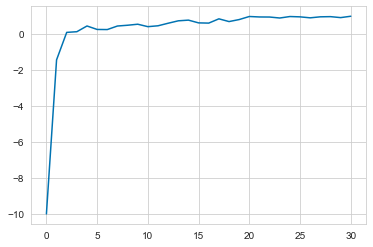

In [16]:
plt.plot(rewards_x_4)
print(rewards_x_4[-1])

0.023


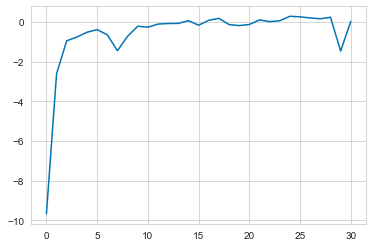

In [17]:
plt.plot(rewards_0_4)
print(rewards_0_4[-1])

### Dueling

In [90]:
class DuelingDQN_model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv_out_size = 5
        self.n_cols = 4
        self.n_rows = 4
        self.conv = nn.Conv2d(3, self.conv_out_size, kernel_size=3, stride=1, padding=1)
        self.l2 = nn.Linear(self.conv_out_size * self.n_cols * self.n_rows, self.n_cols * self.n_rows)

        self.value_stream = nn.Linear(self.n_cols * self.n_rows, 1)
        self.advantage_stream = nn.Linear( self.n_cols * self.n_rows, self.n_cols * self.n_rows)
        

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size * self.n_cols * self.n_rows)
        x = self.l2(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        Q = value + (advantage - advantage.mean())
        return Q

In [91]:
class DuelingDQNmodel():
    def __init__(self):
        self.env = TicTacToe(n_cols=4, n_rows=4, n_win=3)
        self.n_cols = 4
        self.n_rows = 4
        self.action_size = 16
        self.model = DuelingDQN_model()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.01)

        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state = state_to_tensor(self.env.getState()[0], self.n_rows, self.n_cols)
        x_plays = random.choice([-1, 1])
        if not x_plays:
            state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
            state = state_to_tensor(state[0], self.n_rows, self.n_cols)
        while True:
           
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state)
                else:
                    action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
            next_state = state_to_tensor(next_state[0], self.n_rows, self.n_cols)
            

            if not done:
                next_state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                next_state = state_to_tensor(next_state[0], self.n_rows, self.n_cols)
            if not x_plays:
                if reward in [-1, 1]:
                    reward = reward * -1
            
            transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            if done:
                break

            state = next_state
  
            
        
        
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        print(1)
        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        print(2)
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    def test_play(self, x_plays, n_episodes=1000):
        rewards = 0
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            state = state_to_tensor(state[0], self.n_rows, self.n_cols)
            done = False
            while not done:
                if cur_turn == x_plays:
                    idx = self.select_greedy_action(state)
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
                
                state = state_to_tensor(state, self.n_rows, self.n_cols)
            if reward != -10:
                rewards += reward * x_plays
            else:
                if cur_turn == x_plays:
                    rewards += reward
        return rewards / n_episodes

In [97]:
dqn = DuelingDQNmodel()

rewards_x = []
rewards_0 = []
for e in range(3001):
    dqn.run_episode(e)
    if e % 100 == 0:
        rewards_x.append(dqn.test_play(1))
        rewards_0.append(dqn.test_play(-1))

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


0.82


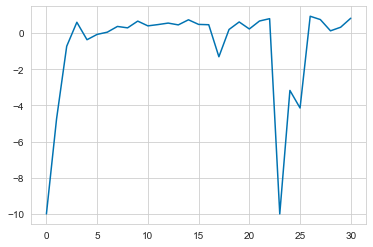

In [100]:
plt.plot(rewards_x)
print(rewards_x[-1])

0.222


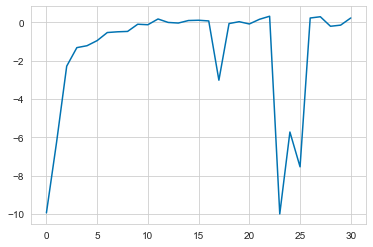

In [101]:
plt.plot(rewards_0)
print(rewards_0[-1])

## ROLLOUT

In [28]:
import copy
def rollout(env, action, Q):
    total_reward = 0
    for i in range(500):
        env_2 = copy.deepcopy(env)
        state_state, reward, done, _ = env_2.step(action)
        state, getEmptySpaces, curTurn = state_state
        while not done:
            if curTurn == 1:
                if state in Q:
                    id_next = np.argmax(Q[state])
                else:
                    id_next = np.random.randint(len(getEmptySpaces))
                next_action = getEmptySpaces[id_next]
                state_state, reward, done, _ = env_2.step(next_action)
                state, getEmptySpaces, curTurn = state_state
            else:
                id_next = np.random.randint(len(getEmptySpaces))
                next_action = getEmptySpaces[id_next]
                state_state, reward, done, _ = env_2.step(next_action)
                state, getEmptySpaces, curTurn = state_state
        total_reward += reward
    return total_reward / 1000

In [29]:
def game_rollout(env, Q):
    env.reset()
    state, getEmptySpaces, curTurn = env.getState()
    done = False
    steps = []
    while not done:
        bestreward = rollout(env, getEmptySpaces[0], Q)
        num = 0
        for i in range(1, len(getEmptySpaces)):
            if bestreward < rollout(env, getEmptySpaces[i], Q):
                bestreward = rollout(env, getEmptySpaces[i], Q)
                num = i
        next_action = getEmptySpaces[num]
        steps.append((state, next_action))
        state_state, reward, done, _ = env.step(next_action)
        state, getEmptySpaces, curTurn = state_state
        if not done:
            state_state, reward, done, _ = env.step(random.choice(env.getEmptySpaces()))
            state, getEmptySpaces, curTurn = state_state
    return steps, reward

In [31]:
env_3 = TicTacToe(n_cols=3, n_rows=3, n_win=3)
n_cols = 3
alpha = 0.1
gamma = 0.1
Q_X_3 = {}
rez_sum = 0
avg_rew = []
for i in range(1000):
    steps, reward = game_rollout(env_3, Q_X_3)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_X_3)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

0.988


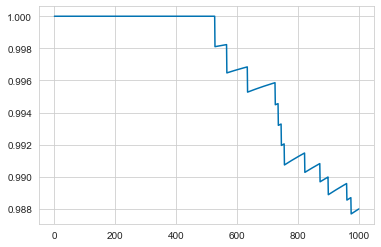

In [32]:
plt.plot(avg_rew)
print(avg_rew[-1])

Запустим алгоритм для ноликов

In [35]:
def game_rollout_0(env, Q):
    env.reset()
    state, getEmptySpaces, curTurn = env.getState()
    state_state, reward, done, _ = env.step(random.choice(env.getEmptySpaces()))
    state, getEmptySpaces, curTurn = state_state
    done = False
    steps = []
    while not done:
        bestreward = rollout(env, getEmptySpaces[0], Q)
        num = 0
        for i in range(1, len(getEmptySpaces)):
            if bestreward < rollout(env, getEmptySpaces[i], Q):
                bestreward = rollout(env, getEmptySpaces[i], Q)
                num = i
        next_action = getEmptySpaces[num]
        steps.append((state, next_action))
        state_state, reward, done, _ = env.step(next_action)
        state, getEmptySpaces, curTurn = state_state
        if not done:
            state_state, reward, done, _ = env.step(random.choice(env.getEmptySpaces()))
            state, getEmptySpaces, curTurn = state_state
    return steps, reward

In [36]:
env_3 = TicTacToe(n_cols=3, n_rows=3, n_win=3)
n_cols = 3
alpha = 0.1
gamma = 0.1
Q_0_3 = {}
rez_sum = 0
avg_rew = []
for i in range(1000):
    steps, reward = game_rollout_0(env_3, Q_0_3)
    q_learning(steps, reward, n_cols, alpha, gamma, Q_0_3)
    rez_sum += reward
    avg_rew.append(rez_sum / (i + 1))

0.987


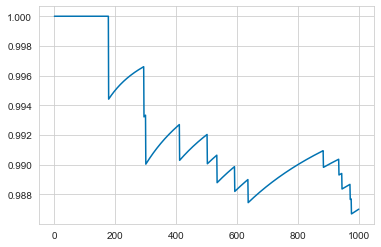

In [37]:
plt.plot(avg_rew)
print(avg_rew[-1])